In [1]:
import torch
import skripsi_program
from skripsi_program import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    LSSVR,
    StandardScaler,
    reduce_coeff,
    zero_coeff,
    # rmse,
    # mse,
    # r2_score,
    # r2_expected_score,
)
import numpy as np
from torchmetrics.functional import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    relative_squared_error,
    symmetric_mean_absolute_percentage_error
)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
generator = torch.Generator().manual_seed(43)
mode = 20
modes = [mode] * 2
prod_modes = int(np.prod(modes))
num_samples = 1001
k = FourierBasis.waveNumber(mode)
u_coeff_clean = FourierBasis.generateCoeff(
    num_samples, prod_modes, generator=generator, random_func=torch.rand
).view(num_samples, *modes)
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * (k.T * k) / prod_modes
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * (k.T * k) / prod_modes  # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape, utt_coeff_clean.shape

(torch.Size([1001, 20, 20]), torch.Size([1001, 20, 20]))

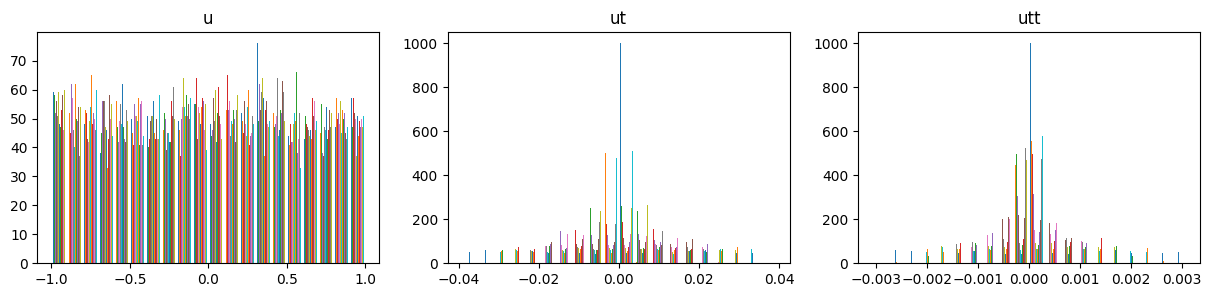

In [4]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

torch.Size([1001, 50, 50])

tensor(0.5234)

tensor(0.1588)

tensor(15.9847)

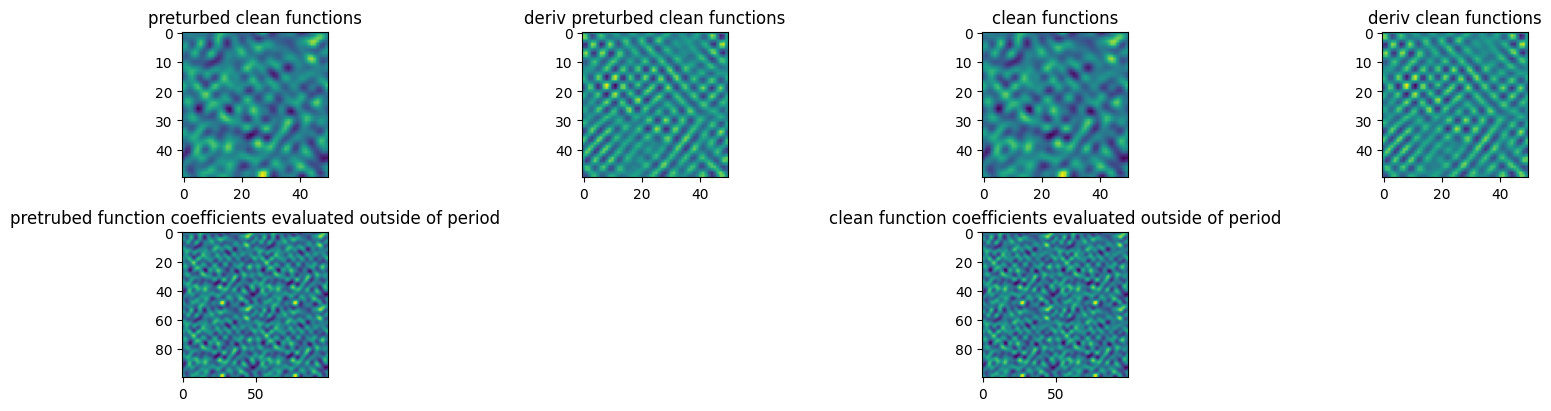

In [5]:
period = 1.0
periods = [period] * len(modes)
sample_freq = 50.0
sample_step = period / sample_freq
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
points_tt = torch.concat([t.flatten().unsqueeze(-1) for t in tt], 1)
u_basis = FourierBasis(u_coeff_clean, periods)
ut_basis = FourierBasis(ut_coeff_clean, periods)
utt_basis = FourierBasis(utt_coeff_clean, periods)
u_clean = u_basis(points_tt).real.view((-1, *(int(sample_freq),) * 2))
ut_clean = ut_basis(points_tt).real.view((-1, *(int(sample_freq),) * 2))
utt_clean = utt_basis(points_tt).real.view((-1, *(int(sample_freq),) * 2))
u = u_clean + torch.randn_like(u_clean) * 0.05 * u_clean.std()
ut = ut_clean + torch.randn_like(ut_clean) * 0.05 * ut_clean.std()
utt = utt_clean + torch.randn_like(utt_clean) * 0.05 * utt_clean.std()
u_coeff = reduce_coeff(FourierBasis.transform(u), modes)
ut_coeff = reduce_coeff(FourierBasis.transform(ut), modes)
utt_coeff = reduce_coeff(FourierBasis.transform(utt), modes)
u_shape = u.shape


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = (
        to_real_coeff(u_coeff.flatten(1)),
        to_real_coeff(u_coeff_clean.flatten(1)),
    )
    r2 = r2_score(u_real, u_clean_real)
    MSE = mean_squared_error(u_real, u_clean_real)
    display(u_shape)
    display(r2)
    display(MSE)
    display(20 * u_clean_real.max().log10() - 10 * MSE.pow(2).log10())


signal_stats()


def tmp_plot():
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(241)
    plt.imshow(u[2].real)
    plt.title("preturbed clean functions")
    plt.subplot(242)
    plt.imshow(utt[2].real)
    plt.title("deriv preturbed clean functions")
    plt.subplot(243)
    plt.imshow(u_clean[2].real)
    plt.title("clean functions")
    plt.subplot(244)
    plt.imshow(utt_clean[2].real)
    plt.title("deriv clean functions")
    x = torch.arange(-1, 1, sample_step)
    tmp = [x for i in range(len(modes))]
    xx = torch.meshgrid(tmp, indexing="ij")
    points = torch.concat([x.flatten().unsqueeze(-1) for x in xx], 1)
    u_eval = (
        FourierBasis(u_coeff[2, None], periods=periods)
        (points)
        .view((-1, *xx[0].shape))
    )
    u_clean_eval = (
        FourierBasis(u_coeff_clean[2, None], periods=periods)
        (points)
        .view((-1, *xx[0].shape))
    )
    plt.subplot(245)
    plt.imshow(u_eval[0].real)
    plt.title("pretrubed function coefficients evaluated outside of period")
    plt.subplot(247)
    plt.imshow(u_clean_eval[0].real)
    plt.title("clean function coefficients evaluated outside of period")
    plt.show()


tmp_plot()

In [6]:
utt_coeff.shape

torch.Size([1001, 20, 20])

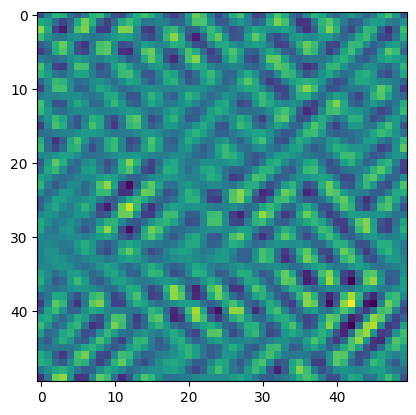

In [7]:
from torch.utils.data import TensorDataset, random_split

input_data = (utt.flatten(1), utt_coeff.flatten(1))
output_data = (u.flatten(1), u_coeff.flatten(1))
# data = (utt, utt_coeff, u, u_coeff_zeroed)
# (utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = data
scaler = StandardScaler().fit(input_data)
input_data_scaled = scaler.transform(input_data)
dataset = TensorDataset(*input_data_scaled, *output_data)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.imshow(dataset[3][0].view(utt.shape[1:]))
plt.show()

In [8]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_input_train = f_train
f_input_train = to_real_coeff(f_coeff_train)
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_input_test = f_test
f_input_test = to_real_coeff(f_coeff_test)

# model = SpectralSVR(FourierBasis(periods=periods), C=41.6207,sigma=4.0776, kernel="linear")
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=100.027,
    # C=200.10,
    # sigma=1.0,
    sigma=f_input_train.var(0).sum().pow(0.5) * 1.09,
    # sigma=70.0,
    # kernel="linear",
    kernel="rbf",
    # verbose="LSSVR",
)
# model.train(f_input_train, u_coeff_train * 900/200, list(u_coeff_zeroed.shape[1:]))
model.train(f_input_train, u_coeff_train, modes).test(f_input_test, u_coeff_test)
# lssvr.fit(points_sampled, u_sampled.T)

transform u_coeff to real


{'mse': 0.06922517716884613,
 'rmse': 0.2631067931652069,
 'mae': 0.17261990904808044,
 'r2': 0.5699980854988098,
 'r2_abs': 0.5699980854988098,
 'smape': 0.7666447162628174,
 'rse': 0.4300019145011902,
 'rrse': 0.5387235879898071,
 'pred_nan_sum': 0}

In [9]:
u_pred = model.forward(f_input_test, points_tt)
u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
# u_coeff_pred = u_coeff_pred * u_coeff_test.std() / u_coeff_pred.std()
# u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_pred_basis = FourierBasis(u_coeff_pred.view((-1, *modes)), periods)
u_basis_pred = u_pred_basis(points_tt).real.view((-1, *tt[0].shape))
# u_pred = lssvr.predict(points_tt).T
u_pred.shape

torch.Size([200, 2500])

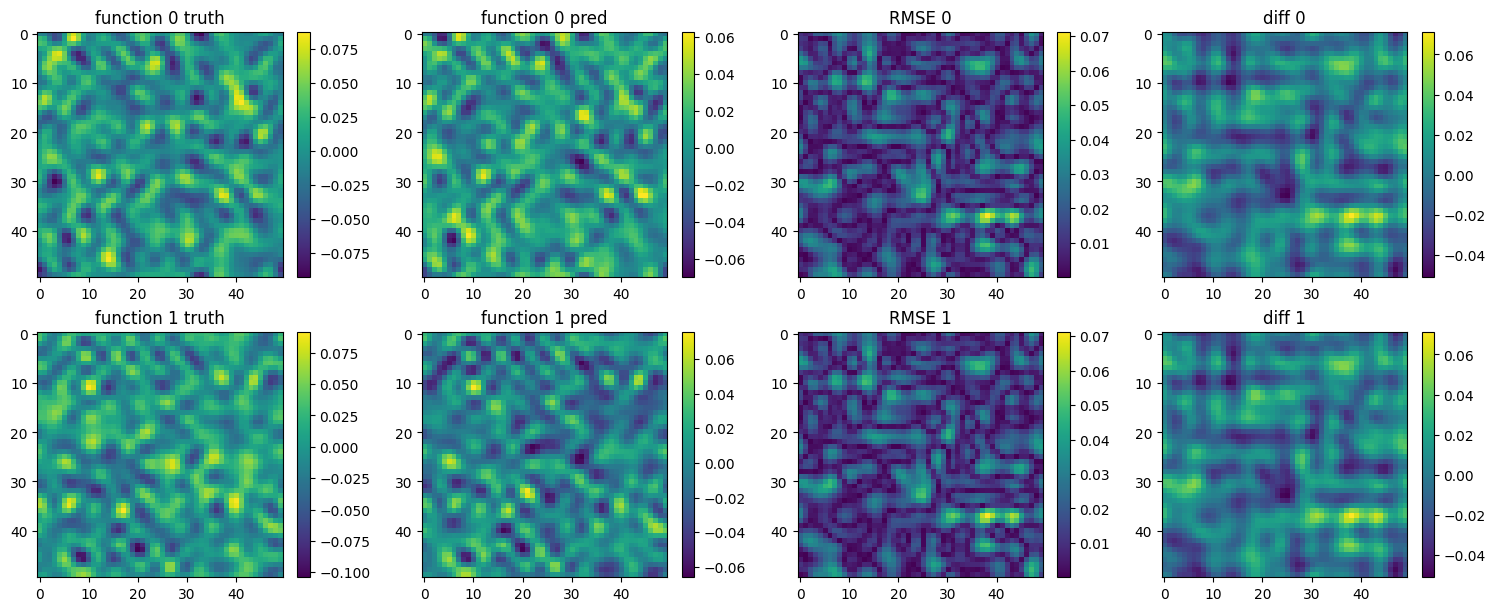

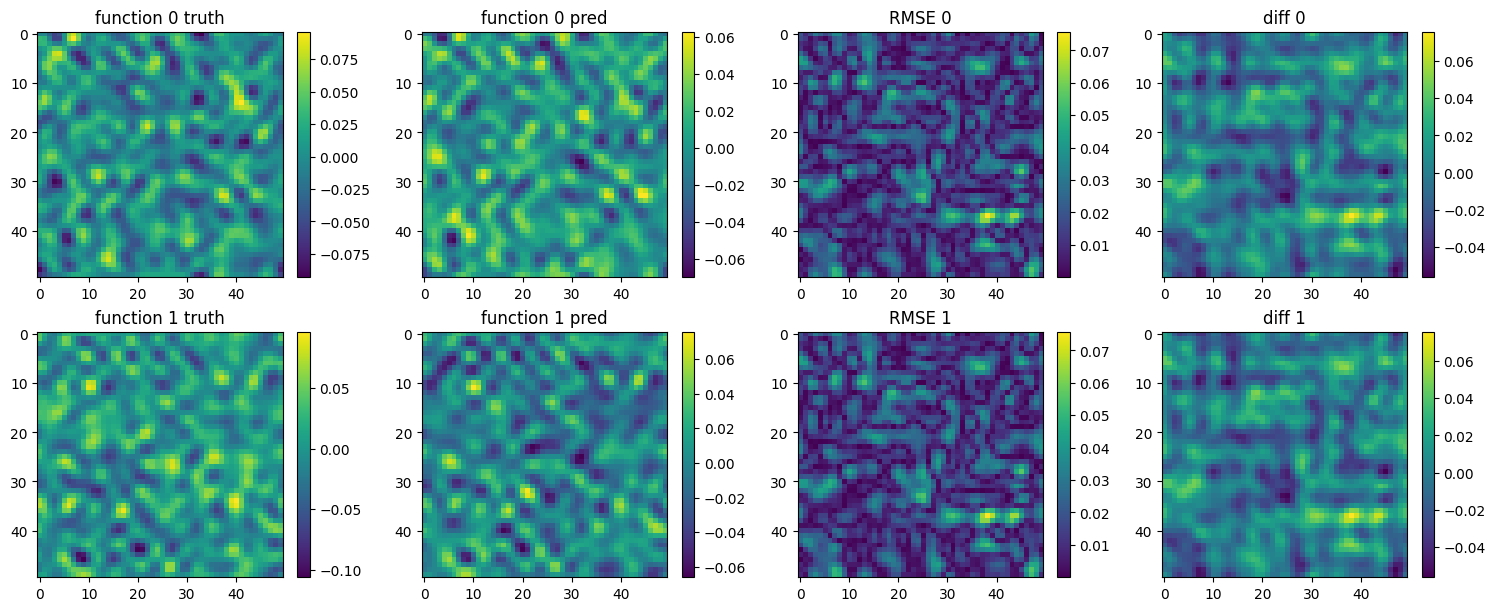

In [10]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_eval = (
    FourierBasis(u_coeff_test.view((-1, *modes)))
    (points_tt)
    .real.view((-1, *tt[0].shape))
)
# u_coeff_clean_scaled = u_coeff_clean
# u_coeff_clean_scaled = scaler.get_subset_scaler([-1]).transform((u_coeff_clean,))[0][dataset_test.indices]
u_coeff_clean_eval = (
    FourierBasis(u_coeff_clean[dataset_test.indices].view((-1, *modes)))
    (points_tt)
    .real.view((-1, *tt[0].shape))
)


def plot_funcs(u_pred: torch.Tensor, u: torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 4, figsize=[15, n * 3], constrained_layout=True)
    for i in range(n):
        z = axs[i, 0].imshow(u[i].real)
        plt.colorbar(z, ax=axs[i, 0])
        axs[i, 0].set_title(f"function {i} truth")
        z_pred = axs[i, 1].imshow(u_pred[i].real)
        plt.colorbar(z_pred, ax=axs[i, 1])
        axs[i, 1].set_title(f"function {i} pred")
        z_rmse = axs[i, 2].imshow(
            mean_squared_error(
                u_pred[n].flatten(0).unsqueeze(0),
                u[n].flatten(0).unsqueeze(0),
                squared=False,
                num_outputs=int(np.prod(tt[0].shape)),
            ).view(tt[0].shape),
        )
        plt.colorbar(z_rmse, ax=axs[i, 2])
        axs[i, 2].set_title(f"RMSE {i}")
        z_diff = axs[i, 3].imshow(u_pred[n] - u[n])
        plt.colorbar(z_diff, ax=axs[i, 3])
        axs[i, 3].set_title(f"diff {i}")

    plt.show()


# plot_funcs(u_pred.real, u_test_eval.real, 2)
# plot_funcs(u_pred, u_coeff_clean_eval, 2)
plot_funcs(u_basis_pred.real, u_test_eval.real, 2)
plot_funcs(u_basis_pred.real, u_coeff_clean_eval, 2)

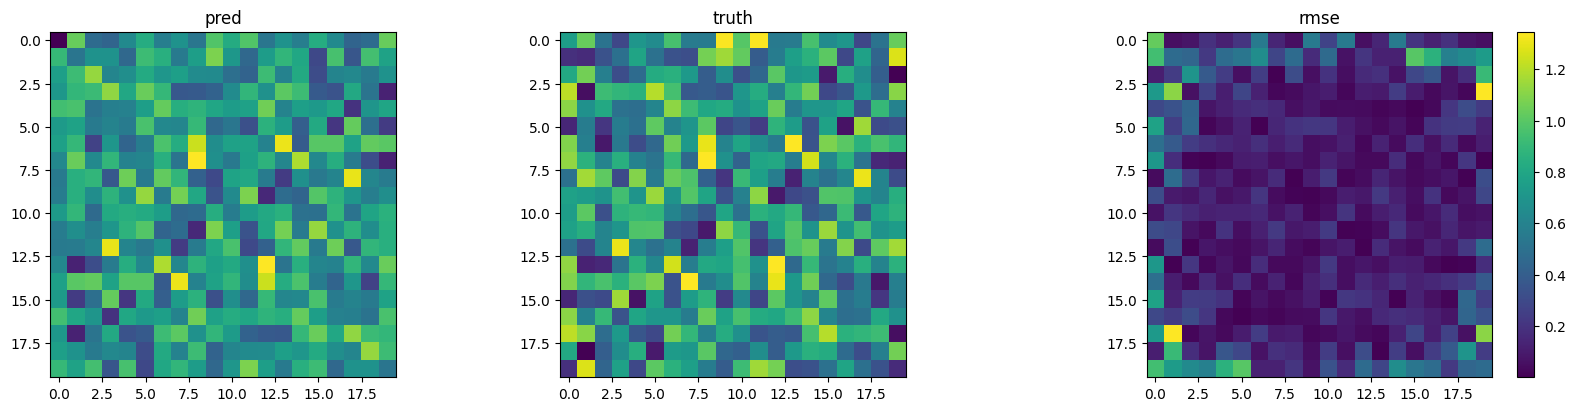

In [11]:
def plot_coeffs(coeff_pred: torch.Tensor, coeff: torch.Tensor, n=0):
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(131)
    plt.imshow(coeff_pred[n].real.view(modes))
    plt.title("pred")
    plt.subplot(132)
    plt.imshow(coeff[n].real.view(modes))
    plt.title("truth")
    plt.subplot(133)
    plt.imshow(
        mean_squared_error(
            coeff_pred[n].real.unsqueeze(0),
            coeff[n].real.unsqueeze(0),
            squared=False,
            num_outputs=coeff.shape[1],
        ).view(modes),
    )
    plt.colorbar()
    plt.title("rmse")
    plt.show()


plot_coeffs(u_coeff_pred, u_coeff_test, 1)

In [12]:
u_coeff_pred[0].real.shape, u_coeff_test.shape

(torch.Size([400]), torch.Size([200, 400]))

In [13]:
mean_squared_error(
            u_coeff_pred[0].real.unsqueeze(0),
            u_coeff_test[0].real.unsqueeze(0),
            squared=False,
            num_outputs=u_coeff_test.shape[1],
        ).shape

torch.Size([400])

In [25]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test.view((-1, *modes)), periods=periods)
u_inv = u_test_basis(points_tt).real
inverse_pred = model.inverse(
    u_inv,
    points_tt,
    epochs=5000,
    lr=1e-3,
    loss_fn=lambda x, y: -r2_score(x, y),
    gain=1e-2,
).detach()

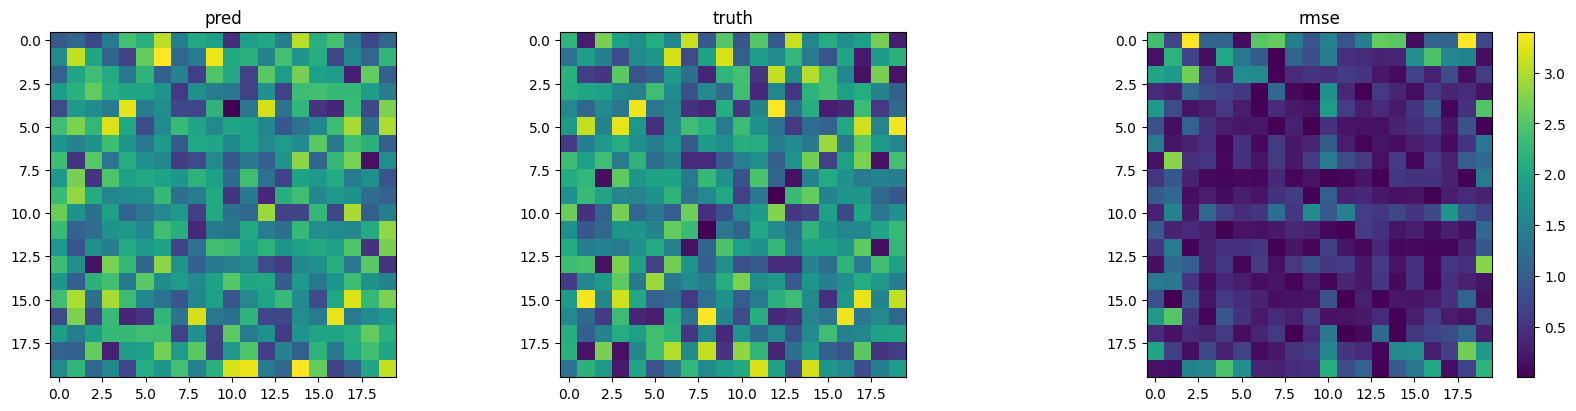

In [26]:
f_truth = f_coeff_test
# f_truth = to_real_coeff(f_coeff_test)
# f_truth = FourierBasis(periods=periods)(points_tt, f_coeff_test, periods=periods,modes=modes).real
# plot_funcs(inverse_pred, f_truth, n=10)
plot_coeffs(to_complex_coeff(inverse_pred), f_truth)

In [27]:
preds = to_complex_coeff(inverse_pred).real
targets = f_truth.real
(
    mean_squared_error(preds, targets),
    r2_score(preds, targets),
    mean_absolute_error(preds, targets),
    symmetric_mean_absolute_percentage_error(preds, targets),
    f_truth.shape,
)


(tensor(0.9858),
 tensor(-0.3374),
 tensor(0.6691),
 tensor(0.8564),
 torch.Size([10, 400]))

In [ ]:
# tmp_test = torch.randn((2000, 2000))
# tmp_unscaled = LSSVR(kernel="tri", sigma=1.0)
# tmp_prod = 1 - tmp_unscaled._batched_K(tmp_test, tmp_test)
# display(tmp_prod)
# tmp_sigma = tmp_prod.max()
# tmp_model = LSSVR(kernel="rbf", sigma =tmp_test.var(0).sum()**.5)
# tmp_gram = tmp_model._batched_K(tmp_test,tmp_test)
# display(tmp_gram)
# def is_psd(mat):
#     return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())
# #Test:
# display(is_psd(tmp_gram), is_psd(tmp_prod))
# model.svr.K
# display((tmp_gram == tmp_gram.T).all())
# tmp_eig = torch.linalg.eigvals(tmp_gram).real
# display(tmp_eig[(tmp_eig>=0 )== False], tmp_eig.shape)

In [ ]:
# aa = torch.randn((3,4))
# aa

tensor([[ 0.3833,  0.1477, -1.1046, -0.7194],
        [-0.2141,  1.3817,  0.9674,  0.4325],
        [ 0.2171,  1.0817,  0.1782, -0.0994]])

In [ ]:
# aa[torch.tensor([1,2])] = 0.0

In [ ]:
# aa

tensor([[ 0.3833,  0.1477, -1.1046, -0.7194],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])